In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from kaggle_datasets import KaggleDatasets
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.image as image
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# View the file paths and value counts

In [2]:
GCS_PATH = '/kaggle/input/chest-xray-pneumonia'
train_path = GCS_PATH + '/chest_xray/train/*/*'
test_path = GCS_PATH + '/chest_xray/test/*/*'
val_path = GCS_PATH + '/chest_xray/val/*/*'
train_files = glob.glob(train_path)
test_files = glob.glob(test_path)
val_files = glob.glob(val_path)

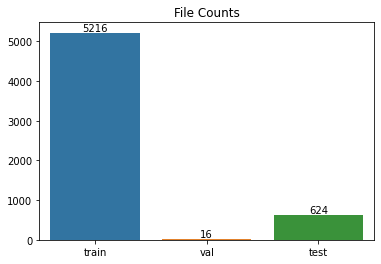

In [3]:
file_counts = [len(train_files), len(val_files), len(test_files)]
total_files = len(train_files) + len(val_files) + len(test_files)

ax = sns.barplot(y=file_counts, x=['train', 'val', 'test'])
for i in ax.containers:
    ax.bar_label(i, )
    
plt.title('File Counts')
plt.show()

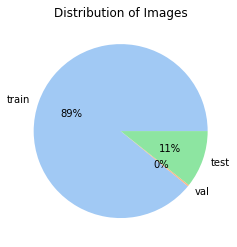

In [4]:
data = [round(100*x / total_files, 2) for x in file_counts] 
colors = sns.color_palette('pastel')
plt.pie(data, labels=['train', 'val', 'test'], autopct='%.0f%%', colors=colors )
plt.title('Distribution of Images')
plt.show()

#### The number of validation images is significantly too small. The ideal would be **60-20-20** for **train-val-test** percentage.

#### One approach is to combine all the files and redistribute them into the proper percentages

### Normal - Pneumonia Counts

In [5]:
pct_df = pd.DataFrame(columns = ['data_set', 'label', 'pct'], index = range(6))

totals = {'train':5216, 'val':16, 'test':624}

row = 0

for set_name in ['train', 'val', 'test']:
    for category in ['NORMAL', 'PNEUMONIA']:
        path = f'{GCS_PATH}/chest_xray/{set_name}/{category}/*'
        files = glob.glob(path)
        pct_df.iloc[row, 0] = set_name
        pct_df.iloc[row, 1] = category
        pct_df.iloc[row, 2] = round(100 * len(files) / totals[set_name], 1)
        row += 1
        
pct_df

,data_set,label,pct
0,train,NORMAL,25.7
1,train,PNEUMONIA,74.3
2,val,NORMAL,50.0
3,val,PNEUMONIA,50.0
4,test,NORMAL,37.5
5,test,PNEUMONIA,62.5


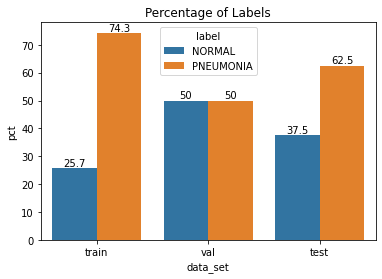

In [6]:
ax = sns.barplot(x=pct_df['data_set'], y=pct_df['pct'], hue=pct_df['label'])
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Percentage of Labels')
plt.show()

## Distribution Across Groups Analysis

#### The distribution of Pneumonia and Normal is not similar between the different groups. This will cause some serious issues when optimizing the model. 

#### The biggest issue is that the validation set is not the same distribution as the test set. This will mean that a model that performs well on the validation set may not do well on the test set. 

#### The validation and test set need to be redistributed to be similar

## Distribution of Pneumonia vs Normal Analysis

#### Because there are significantly more Pneumonia images than Normal images, there will need to be some action taken to account for the imbalance.
- Eliminating pneumonia images to make a more even distribution of labels is an option but with the small number of total images, this will hinder the learning and model performance significantly and is not recommended
- Adding weights to the two classes can help the model to assign a higher penalty for incorrect predictions on the Normal images. This should help the model not favor predicting Pneumonia which will be favored in a skewed distribution.

# Pixel Intensities

### Look at pixel intensity between the Normal and Pneumonia between the three sets

In [7]:
def show_image_distr(file_path):
    
    img_data = image.imread(file_path)
    
    f = plt.figure()
    f.set_figwidth(10)
    
    re_pattern = '.+/(PNEUMONIA|NORMAL)/.+'
    groups = re.match(re_pattern, file_path)
    label = groups[1]
    
    image_plt = f.add_subplot(1, 2, 1)
    image_plt.set_title(f'{label}')
    plt.imshow(img_data, cmap='gray')
    
    intensity_plt = f.add_subplot(1, 2, 2)
    intensity_plt.set_title('Pixel Intensity Distribution')
    plt.ylim(0, 30000)
    plt.hist(img_data.ravel(), bins=256)
    
    plt.show()

In [8]:
train_files[0]

'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'

Example of a Training Image Pixel Intesity Distribution


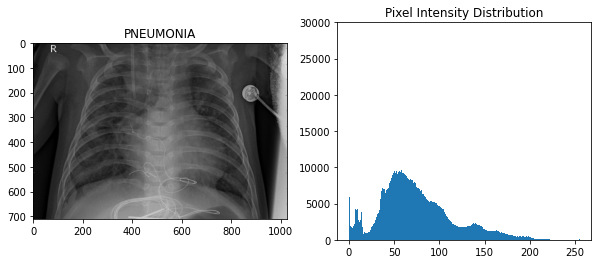

In [9]:
print('Example of a Training Image Pixel Intesity Distribution')
show_image_distr(train_files[0])

Example of a Testing Image Pixel Intesity Distribution


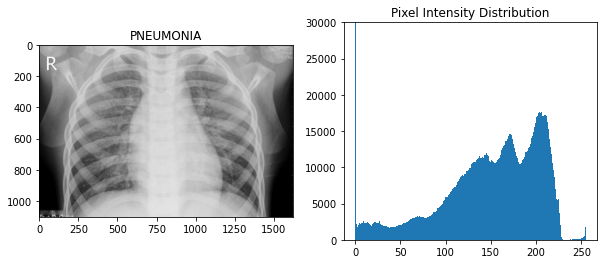

In [10]:
print('Example of a Testing Image Pixel Intesity Distribution')
show_image_distr(test_files[0])

Example of a Validation Image Pixel Intesity Distribution


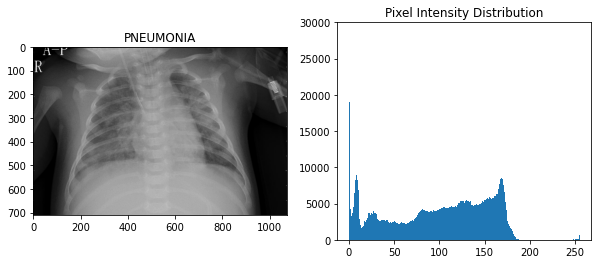

In [11]:
print('Example of a Validation Image Pixel Intesity Distribution')
show_image_distr(val_files[1])

In [12]:
train_pneum_files = glob.glob(GCS_PATH + '/chest_xray/train/PNEUMONIA/*')
train_norm_files = glob.glob(GCS_PATH + '/chest_xray/train/NORMAL/*')
test_pneum_files = glob.glob(GCS_PATH + '/chest_xray/test/PNEUMONIA/*')
test_norm_files = glob.glob(GCS_PATH + '/chest_xray/test/NORMAL/*')
val_pneum_files = glob.glob(GCS_PATH + '/chest_xray/val/PNEUMONIA/*')
val_norm_files = glob.glob(GCS_PATH + '/chest_xray/val/NORMAL/*')

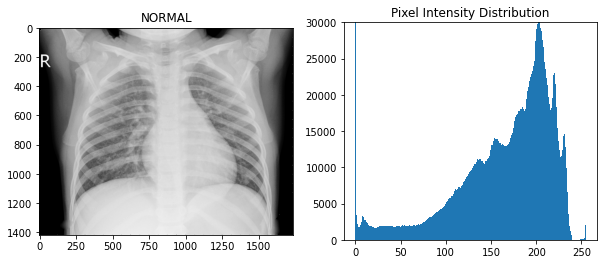

In [13]:
show_image_distr(val_norm_files[0])

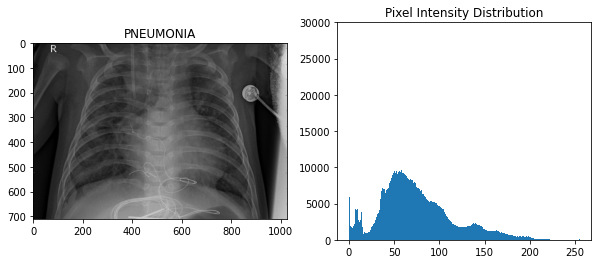

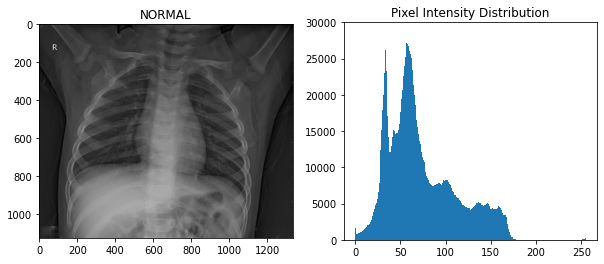

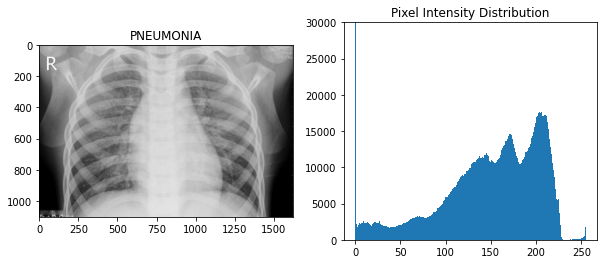

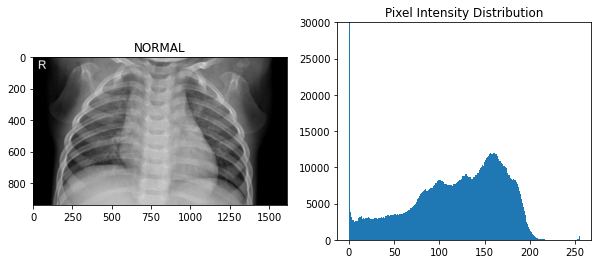

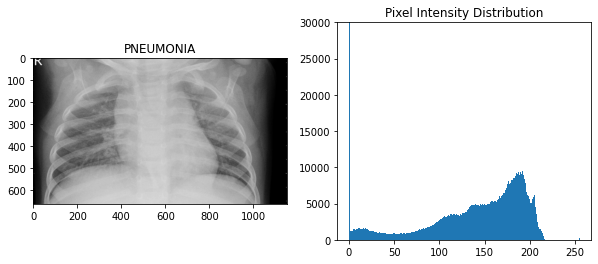

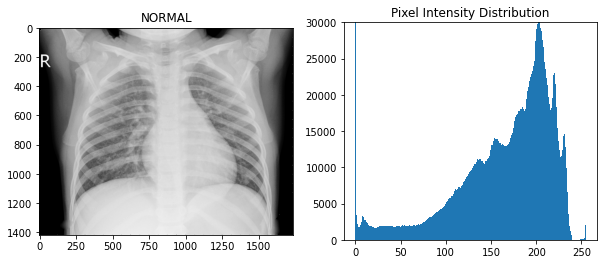

In [14]:
# compare pneumonia and normal for one image from each group
show_image_distr(train_pneum_files[0])
show_image_distr(train_norm_files[0])
show_image_distr(test_pneum_files[0])
show_image_distr(test_norm_files[0])
show_image_distr(val_pneum_files[0])
show_image_distr(val_norm_files[0])

## Sample Image Analysis


It becomes clear from the pixel intensities that there can be a significant difference based on how bright the X-ray is. Since these are from real X-rays, it can be assumed that the model will have to perform well on dark and bright X-rays. The best scenario is to make sure the distrubtion of images is very well shuffled and distributed proportionally across all sets of the groups.